# Two Fastest Gravity Inversion Methods on a Synthetic Density Model
### Author's Gravity Inversion Methods illustrated on a Synthetic Density Model. This notebook provides self contained code to build the synthetic model and calculate the gravity inversion models by two different ways and estimate the accuracy - just run the notebook to try. The full processing requires 3 minutes on macBook Pro 13" Mid 2014
Note: the notebook code is not production ready but simplified version only

See the methods history and introduction by this link (ru):

[Computer Vision Methods for Inverse Geophysical Problem Solution (Методы компьютерного зрения для решения обратной задачи геофизики)](https://habr.com/ru/post/506426/)

and this (en):

[HOWTO: Multi-scale 3D Gravity and Magnetic Inversion modelin](https://www.linkedin.com/pulse/brief-explanation-3d-density-depth-model-construction-pechnikov/)

[The Density-Depth Model by Spectral Fractal Dimension Index](https://www.linkedin.com/pulse/density-model-spectral-fractal-dimension-index-alexey-pechnikov/)

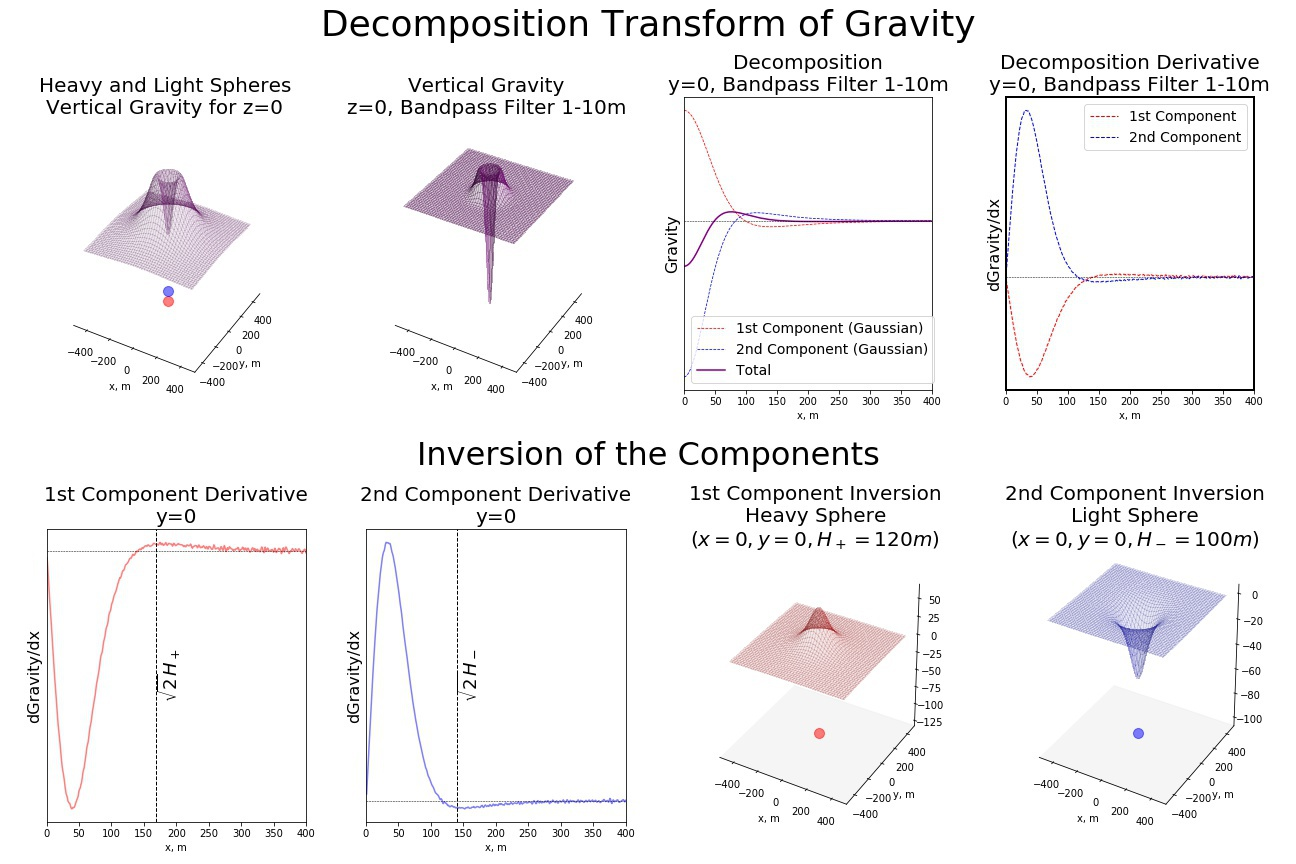

In [1]:
from IPython.display import Image
Image(filename='Inversion of Gravity Field of Deepen Spheres.jpg')

Workflow:

* generate synthetic density model
    (by defined set of 3D density points, where surface points are not physically correct),

* calculates gravity field on the surface from the density model,

* use Radon Transform (also known as Focal Average) to produce the inversion model
    (we use fast simplified transform good enough for our demonstration),

*  compare original model isosurfaces and the inversion ones
    (should be orthogonal by the theory),

* compare original model and the inversion model density-depth profiles
    (should be the same for accurate model and transform).

See also more complex and realistic model:
[3D Synthetic Density Inversion by Circular Hough Transform [Focal Average]](3D%20Synthetic%20Density%20Inversion%20by%20Circular%20Hough%20Transform%20%5BFocal%20Average%5D.ipynb)

In [2]:
# calculation modules
import xarray as xr
import numpy as np
import pandas as pd
import math
from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate, stats

In [3]:
# plotting modules
import matplotlib.pyplot as plt
%matplotlib inline

## Constants and functions

In [4]:
G=6.67408*1e-11
# [m**3]
def volume_sphere(r):
    return 4./3*math.pi*r**3
# delta_density [g/cm**3] -> mass [kg]
def delta_mass_sphere(r, delta_density):
    return 1000.*delta_density*volume_sphere(r)
# [мГал]
def delta_grav(delta_mass, x,y,z):
    return (100.*1000)*G*delta_mass*z/np.power(x**2 + y**2 + z**2, 1.5)

def gaussian(x, y, z, std, amplitude):
    r2 = x**2 + y**2 + z**2
    return amplitude*np.exp(-r2/std**2)

def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1,mode='constant', cval=0) \
            - gaussian_filter(raster.values,g2,mode='constant', cval=0)
    return raster

def spectrum(raster, gammas, dgamma = 1.0):
    rasters = []
    for g in gammas:
        print (g,". ", end = '')
        _raster = raster_filter_range(raster, g-dgamma/2, g+dgamma/2)
        rasters.append(_raster)
    return rasters

# define circular mask
def unit_circle_2d(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt( A[:,None] + A)
    if r <= 2:
        return ((dists-r)<=0).astype(int)
    return ((dists-r)<=0.5).astype(int)

## Modeling Parameters

In [5]:
depth = 50
print ('Model depth, units', depth)
rmax = round(depth*np.sqrt(2))
print ('Transform planar radius, pixel', rmax)
downscale = 1
print ('Reduce model size by factor', downscale)

Model depth, units 50
Transform planar radius, pixel 71
Reduce model size by factor 1


## Synthetic Density Model

In [6]:
# define processing grid
L = 200
Z = 100
x = np.linspace(-L,L,2*L+1)
y = np.linspace(-L,L,2*L+1)
z = -np.arange(1,Z+1)
(xx,yy,zz) = np.meshgrid(x,y,z)

In [7]:
# define sources
X0 = np.array([350,375,400,450,500,550,600,625,650])/2
Y0 = np.array(len(X0)*[0])
Z0 = np.array([50,0,50,25,0+50,25,50,0,50])/2
V0 = [-1,-1,1,-1,-1+0,-1,1,-1,-1]

In [8]:
# save the density sources
pd.DataFrame(list(zip(X0-250, Y0, -Z0, V0)),columns =['X', 'Y', 'Z', 'VALUE'])\
    .to_csv('3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].basic.csv', index=False)

In [9]:
# produce synthetic density
da_density = xr.DataArray(np.zeros(zz.shape),
                          coords={'x': x.astype('float32'), 'y': y.astype('float32'), 'z': z.astype('float32')},
                          dims=['x','y','z']).rename('density')
for (x0,y0,z0,v0) in zip(X0,Y0,Z0,V0):
    da_density.values += gaussian(xx+x0-250, yy+y0, zz+z0, 20, v0)
da_density.values = da_density.transpose('y','x','z').astype('float32').values
da_density['x'] = -da_density.x

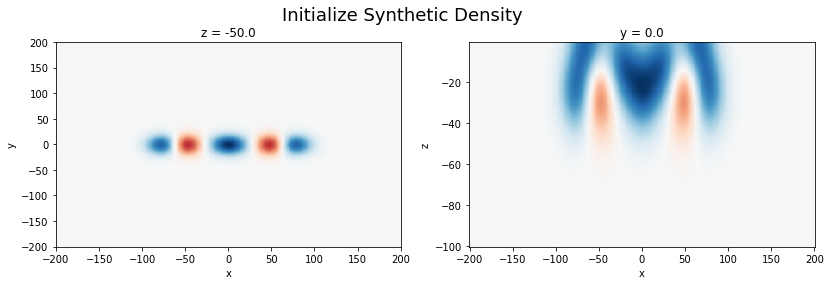

In [10]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 2, 1)
da_density.sel(z=-50,method='nearest').T.plot(ax=ax, add_colorbar=False)

ax = fig.add_subplot(1, 2, 2)
da_density.sel(y=0).T.plot(ax=ax, add_colorbar=False)

plt.suptitle('Initialize Synthetic Density', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.show()

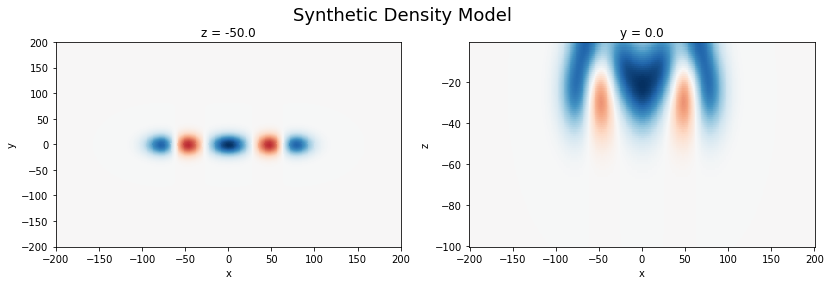

In [11]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 2, 1)
da_density.sel(z=-50,method='nearest').T.plot(ax=ax, add_colorbar=False)

ax = fig.add_subplot(1, 2, 2)
da_density.sel(y=0).T.plot(ax=ax, add_colorbar=False)

plt.suptitle('Synthetic Density Model', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.show()

In [12]:
# save the synthetic density model
da_density.transpose('z','y','x').sel(z=slice(0,-50))\
    .to_netcdf('3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].density.basic.nc')

## Gravity Forward Model

In [13]:
# forward gravity calculation on the surface
def _delta_grav(val, dx, dy, dz):
    return delta_grav(delta_mass_sphere(.5,val), dx, dy, -dz)
da_gravity = xr.apply_ufunc(_delta_grav, da_density, x+da_density.x, y-da_density.y, da_density.z)\
    .sel(z=0, method='nearest')\
    .astype('float32')\
    .rename('gravity')

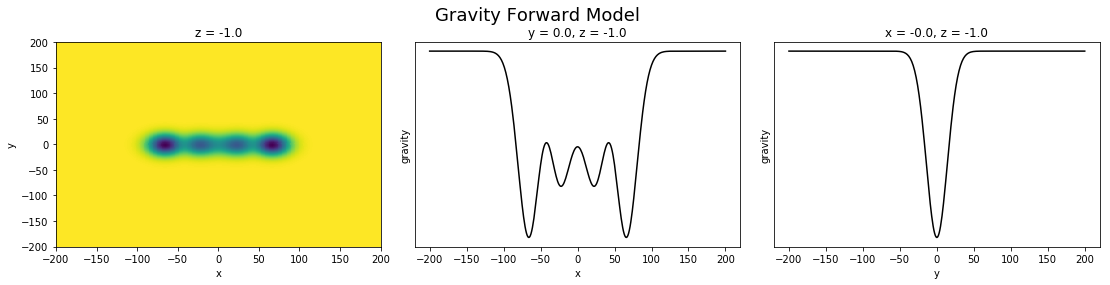

In [14]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(1, 3, 1)
da_gravity.T.plot(ax=ax, add_colorbar=False)

ax = fig.add_subplot(1, 3, 2)
da_gravity.sel(y=0).plot(ax=ax, c='black')
plt.gca().get_yaxis().set_ticks([])

ax = fig.add_subplot(1, 3, 3)
da_gravity.sel(x=0).plot(ax=ax, c='black')
plt.gca().get_yaxis().set_ticks([])

plt.suptitle('Gravity Forward Model', fontsize=18)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.95])
plt.show()

In [15]:
# save the gravity model
da_gravity.transpose('y','x')\
    .to_netcdf('3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].gravity.basic.nc')

## Reduce model size
Note: check accuracy vs calculation speed

In [16]:
if downscale > 1:
    da_gravity = da_gravity.coarsen({'x':downscale, 'y':downscale}, boundary="trim").mean()

## Fractal Dimension Index by Discrete Gravity Spectrum
Note: Fractal Dimension Index is proportional to average density per depth for the area

In [17]:
# discrete spectrum range
gammas = np.arange(1,rmax+1/2,1)
# real z coordinate
depth_fractal = -(gammas[1:] - 1/2)/np.sqrt(2)

In [18]:
%%time
# calculate discrete dravity spectrum
grav_spectrum = spectrum(da_gravity, gammas, 1)
grav_spectrum_stds = [_.sel(x=slice(100,-100),y=slice(-100,100)).std() for _ in grav_spectrum]

1.0 . 2.0 . 3.0 . 4.0 . 5.0 . 6.0 . 7.0 . 8.0 . 9.0 . 10.0 . 11.0 . 12.0 . 13.0 . 14.0 . 15.0 . 16.0 . 17.0 . 18.0 . 19.0 . 20.0 . 21.0 . 22.0 . 23.0 . 24.0 . 25.0 . 26.0 . 27.0 . 28.0 . 29.0 . 30.0 . 31.0 . 32.0 . 33.0 . 34.0 . 35.0 . 36.0 . 37.0 . 38.0 . 39.0 . 40.0 . 41.0 . 42.0 . 43.0 . 44.0 . 45.0 . 46.0 . 47.0 . 48.0 . 49.0 . 50.0 . 51.0 . 52.0 . 53.0 . 54.0 . 55.0 . 56.0 . 57.0 . 58.0 . 59.0 . 60.0 . 61.0 . 62.0 . 63.0 . 64.0 . 65.0 . 66.0 . 67.0 . 68.0 . 69.0 . 70.0 . 71.0 . CPU times: user 8.28 s, sys: 209 ms, total: 8.49 s
Wall time: 8.95 s


In [19]:
# calculate fractality index
slope = np.diff(np.log10(grav_spectrum_stds))/np.diff(np.log10(gammas))
fractal = (3 - (slope/2))

## Circular Hough Transform [Focal Average]
Note: simplified transform is easy but produces some issues (including misrepresented density-depth profile)

In [20]:
%%time
# Radon Transformation (Focal Average)
from scipy.signal import convolve2d
rs = np.arange(rmax)
means = []
for r in rs:
    print (r, end=' ')
    mask = unit_circle_2d(r)
    mask[1:-1,1:-1] -= unit_circle_2d(r-1)
    mean = convolve2d(da_gravity, mask/np.sum(mask), mode='same')
    means.append(mean)
means = np.array(means)
# make dataarray
dx = da_gravity.x.diff('x').values[0]
da_focal = xr.DataArray(means, coords=[dx*rs/np.sqrt(2),-da_gravity.x,da_gravity.y], dims=['z','x','y']).rename('inversion')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 CPU times: user 2min 52s, sys: 3.11 s, total: 2min 55s
Wall time: 3min 2s


In [21]:
# save the inversion model
da_focal.transpose('z','y','x').astype('float32').to_netcdf(
    f'3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].inversion.basic1to{downscale}.nc',
    encoding= {'inversion': {'zlib': True, 'complevel':9}}
)

## Visualize original and inversion models

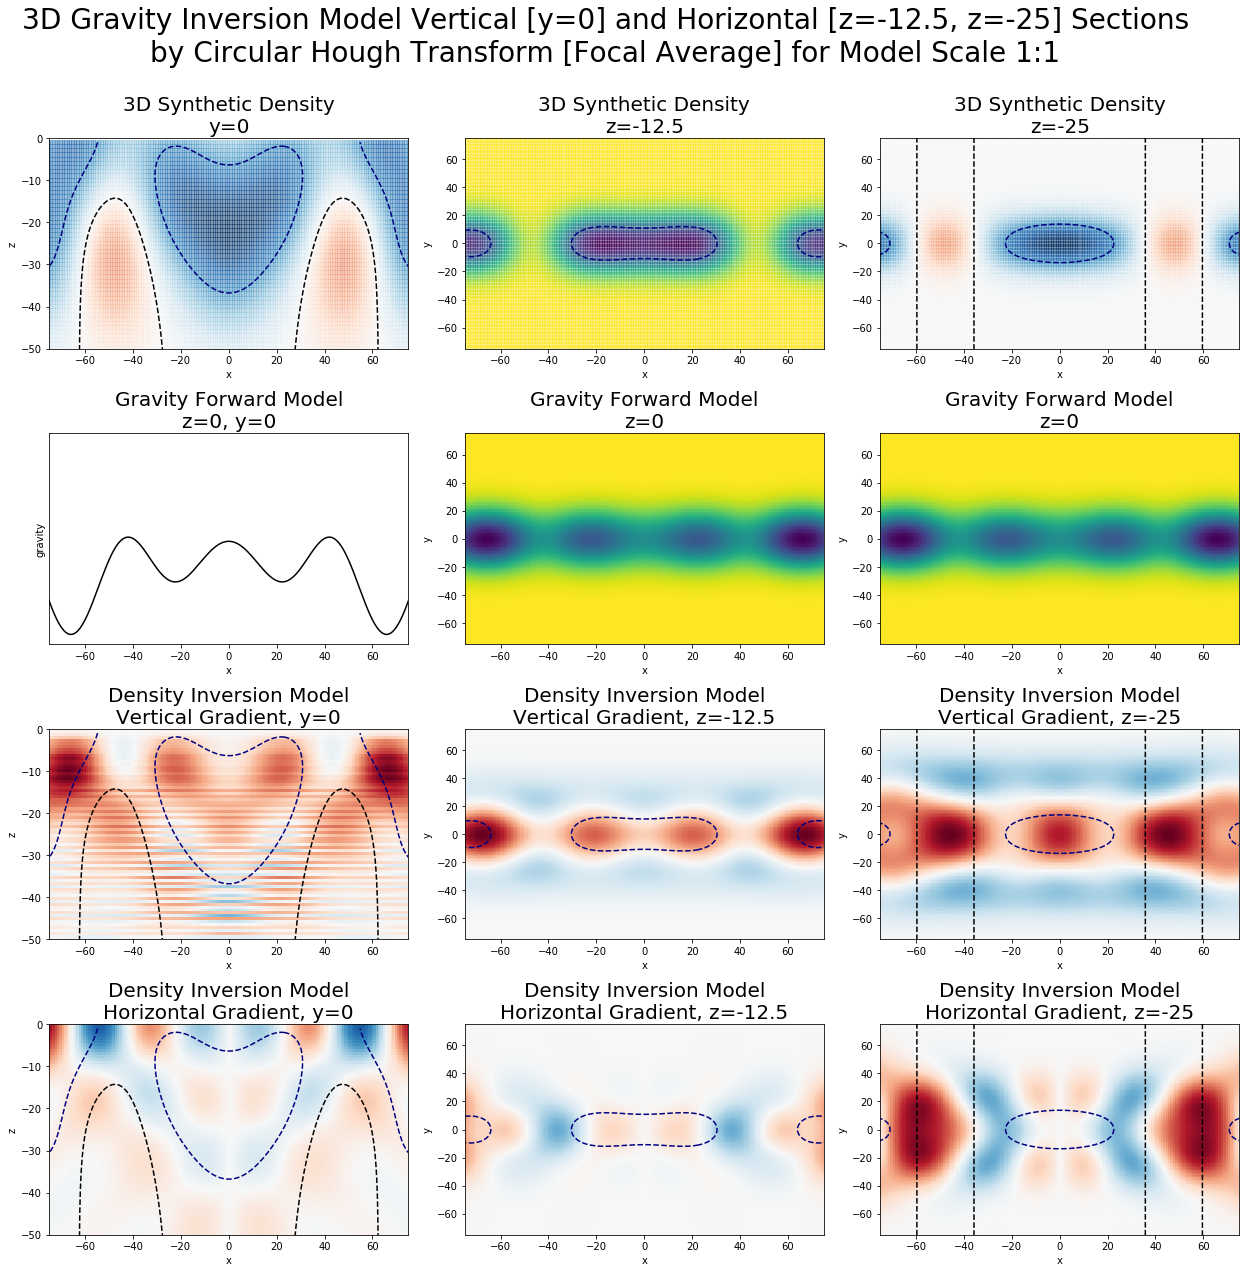

In [22]:
xsize = 75
zsize = 50
levels=[-0.8,0,0.8]
colors=['navy','black','red']

fig = plt.figure(figsize=(18,18))

ax = fig.add_subplot(4, 3, 1)
da_density.sel(y=0, method='nearest').T.plot(ax=ax, alpha=0.5, add_colorbar=False)
da_density.sel(y=0, method='nearest').T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('3D Synthetic Density\ny=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-zsize, 0])

ax = fig.add_subplot(4, 3, 4)
da_gravity.sel(y=0, method='nearest').plot(ax=ax, c='black')
ax.set_title('Gravity Forward Model\nz=0, y=0', fontsize=20)
ax.get_yaxis().set_ticks([])
ax.set_xlim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 7)
# vertical gradient
grd = da_focal.sel(y=0, method='nearest').diff('z')
grd.plot(ax=ax, add_colorbar=False)
da_density.T.sel(y=0, method='nearest').plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nVertical Gradient, y=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-zsize, 0])

ax = fig.add_subplot(4, 3, 10)
# radial gradient (from x gradient)
grd = da_focal.sel(y=0, method='nearest').diff('x')
grd.values[:,:int(len(grd.x)/2+0.5)] = -grd.values[:,:int(len(grd.x)/2+0.5)]
grd.plot(ax=ax, add_colorbar=False)
da_density.sel(y=0).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nHorizontal Gradient, y=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-zsize, 0])

ax = fig.add_subplot(4, 3, 2)
da_density.T.sel(z=-12.5,method='nearest').plot(ax=ax, alpha=0.5, add_colorbar=False)
da_density.T.sel(z=-12.5,method='nearest').plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('3D Synthetic Density\nz=-12.5', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 5)
da_gravity.T.plot(ax=ax, add_colorbar=False)
ax.set_title('Gravity Forward Model\nz=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 8)
# vertical gradient
grd = da_focal.diff('z')
grd.sel(z=-12.5,method='nearest').T.plot(ax=ax, add_colorbar=False)
da_density.sel(z=-12.5,method='nearest').T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nVertical Gradient, z=-12.5', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 11)
# radial gradient (from x gradient)
grd = da_focal.sel(z=-12.5, method='nearest').diff('x').T
grd.values[:,:int(len(grd.x)/2+0.5)] = -grd.values[:,:int(len(grd.x)/2+0.5)]
grd.plot(ax=ax, add_colorbar=False)
da_density.sel(z=-12.5,method='nearest').T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nHorizontal Gradient, z=-12.5', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 3)
da_density.T.sel(z=-25).plot(ax=ax, alpha=0.5, add_colorbar=False)
da_density.T.sel(z=-25).plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('3D Synthetic Density\nz=-25', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 6)
da_gravity.T.plot(ax=ax, add_colorbar=False)
ax.set_title('Gravity Forward Model\nz=0', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 9)
# vertical gradient
grd = da_focal.diff('z')
grd.sel(z=-25,method='nearest').T.plot(ax=ax, add_colorbar=False)
da_density.sel(z=-25).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nVertical Gradient, z=-25', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

ax = fig.add_subplot(4, 3, 12)
# radial gradient (from x gradient)
grd = da_focal.sel(z=-25, method='nearest').diff('x').T
grd.values[:,:int(len(grd.x)/2+0.5)] = -grd.values[:,:int(len(grd.x)/2+0.5)]
grd.plot(ax=ax, add_colorbar=False)
da_density.sel(z=-25).T.plot.contour(ax=ax, levels=levels, colors=colors, linestyles='--')
ax.set_title('Density Inversion Model\nHorizontal Gradient, z=-25', fontsize=20)
ax.set_xlim([-xsize, xsize])
ax.set_ylim([-xsize, xsize])

plt.suptitle(f'3D Gravity Inversion Model Vertical [y=0] and Horizontal [z=-12.5, z=-25] Sections\nby Circular Hough Transform [Focal Average] for Model Scale 1:{downscale}', fontsize=28)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.92])
plt.savefig(f'3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].basic1to{downscale}.jpg', dpi=150, quality=95)
plt.show()

## Model Accuracy Estimation by Density profiles
Calculate Pearson's correlation coefficient between the density profiles

Note: Exclude subsurface depth equal to the used spatial filter above (band 10-11m) due to boundary effects

Note: There is linear scale factor between the density profiles values

In [23]:
# extract inversion model density-depth profile
inverse = da_focal.sel(z=slice(0,-50),x=slice(-100,100),y=slice(-100,100)).mean(['y','x'])
# extract original model density-depth profile
original = da_density.sel(z=slice(0,-50),x=slice(100,-100),y=slice(-100,100)).mean(['y','x'])
# interpolate the original profile on the inversion model 'z' coordinate
f = interpolate.interp1d(original.z, original, fill_value='extrapolate')
original_regridded = f(inverse.z)
# interpolate the fractal index on the inversion model 'z' coordinate
f = interpolate.interp1d(depth_fractal, fractal, fill_value='extrapolate')
fractal_regridded = f(inverse.z)
# exclude depths between 0 and 11m due to boundary effects
df = pd.DataFrame({'orig':original_regridded, 'inv':inverse,'frac':fractal_regridded,'z':inverse.z})
df = df[df.z<-11]

### Visualize Synthetic, Inversion and Fractality Density

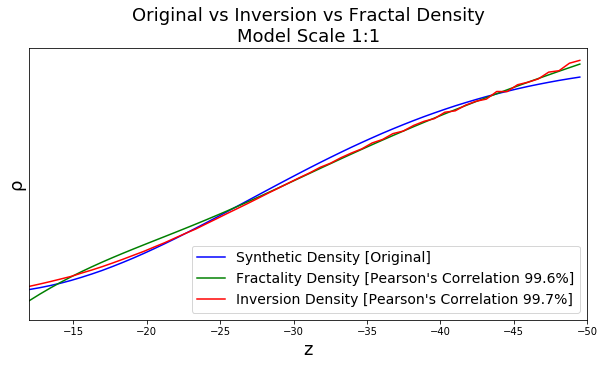

In [24]:
fig = plt.figure(figsize=(10,5))

#ax = fig.add_subplot(4, 3, 1)

plt.plot(df.z.values, df.orig.values, c='blue', label='Synthetic Density [Original]')

# calculate a linear least-squares regression between original and inversion density-depth profiles
inv_frac = stats.linregress(df.frac.values, df.orig.values)
# linearly scale the fractal index
frac_corr = np.round(100*inv_frac.rvalue,1)
plt.plot(df.z.values, inv_frac.intercept + inv_frac.slope*df.frac.values, 'g', label=f"Fractality Density [Pearson's Correlation {frac_corr}%]")
plt.title(f'Original vs Inversion vs Fractal Density\nModel Scale 1:{downscale}', fontsize=18)

# calculate a linear least-squares regression between original and inversion density-depth profiles
inv_res = stats.linregress(df.inv.values, df.orig.values)
# linearly scale the inversion profile
inv_corr = np.round(100*inv_res.rvalue,1)
plt.plot(df.z.values, inv_res.intercept + inv_res.slope*df.inv.values, 'r', label=f"Inversion Density [Pearson's Correlation {inv_corr}%]")
plt.legend(fontsize=14)

plt.ylabel('ρ',fontsize=18)
plt.xlabel('z', fontsize=18)
plt.yticks([])
plt.xlim([-12,-50])

plt.savefig(f'3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].corr.basic1to{downscale}.jpg', dpi=150, quality=95)
plt.show()

## Conclusion

The inversion model reproduces original density on other scale defined by band-pass Gaussian filtering. The filtering allows to generalize the inversion model in wide scale range between 1 pixel and the size of the source gravity grid. Independently of the generalization the density-depth profile for the inversion model is equal to the original one. Density calculated by Fractality Index allows to build the same density-depth profile. Pearson's correlation coefficient between the original and inversion and fractality density-depth profiles estimates the model accuracy.

For practical cases, on top of the inversion density model we use different anomaly detection algorithms (see the simplest derivative-based anomaly detection below). This is our project for the model in Open Source [ParaView](https://www.paraview.org) software on screenshot below:

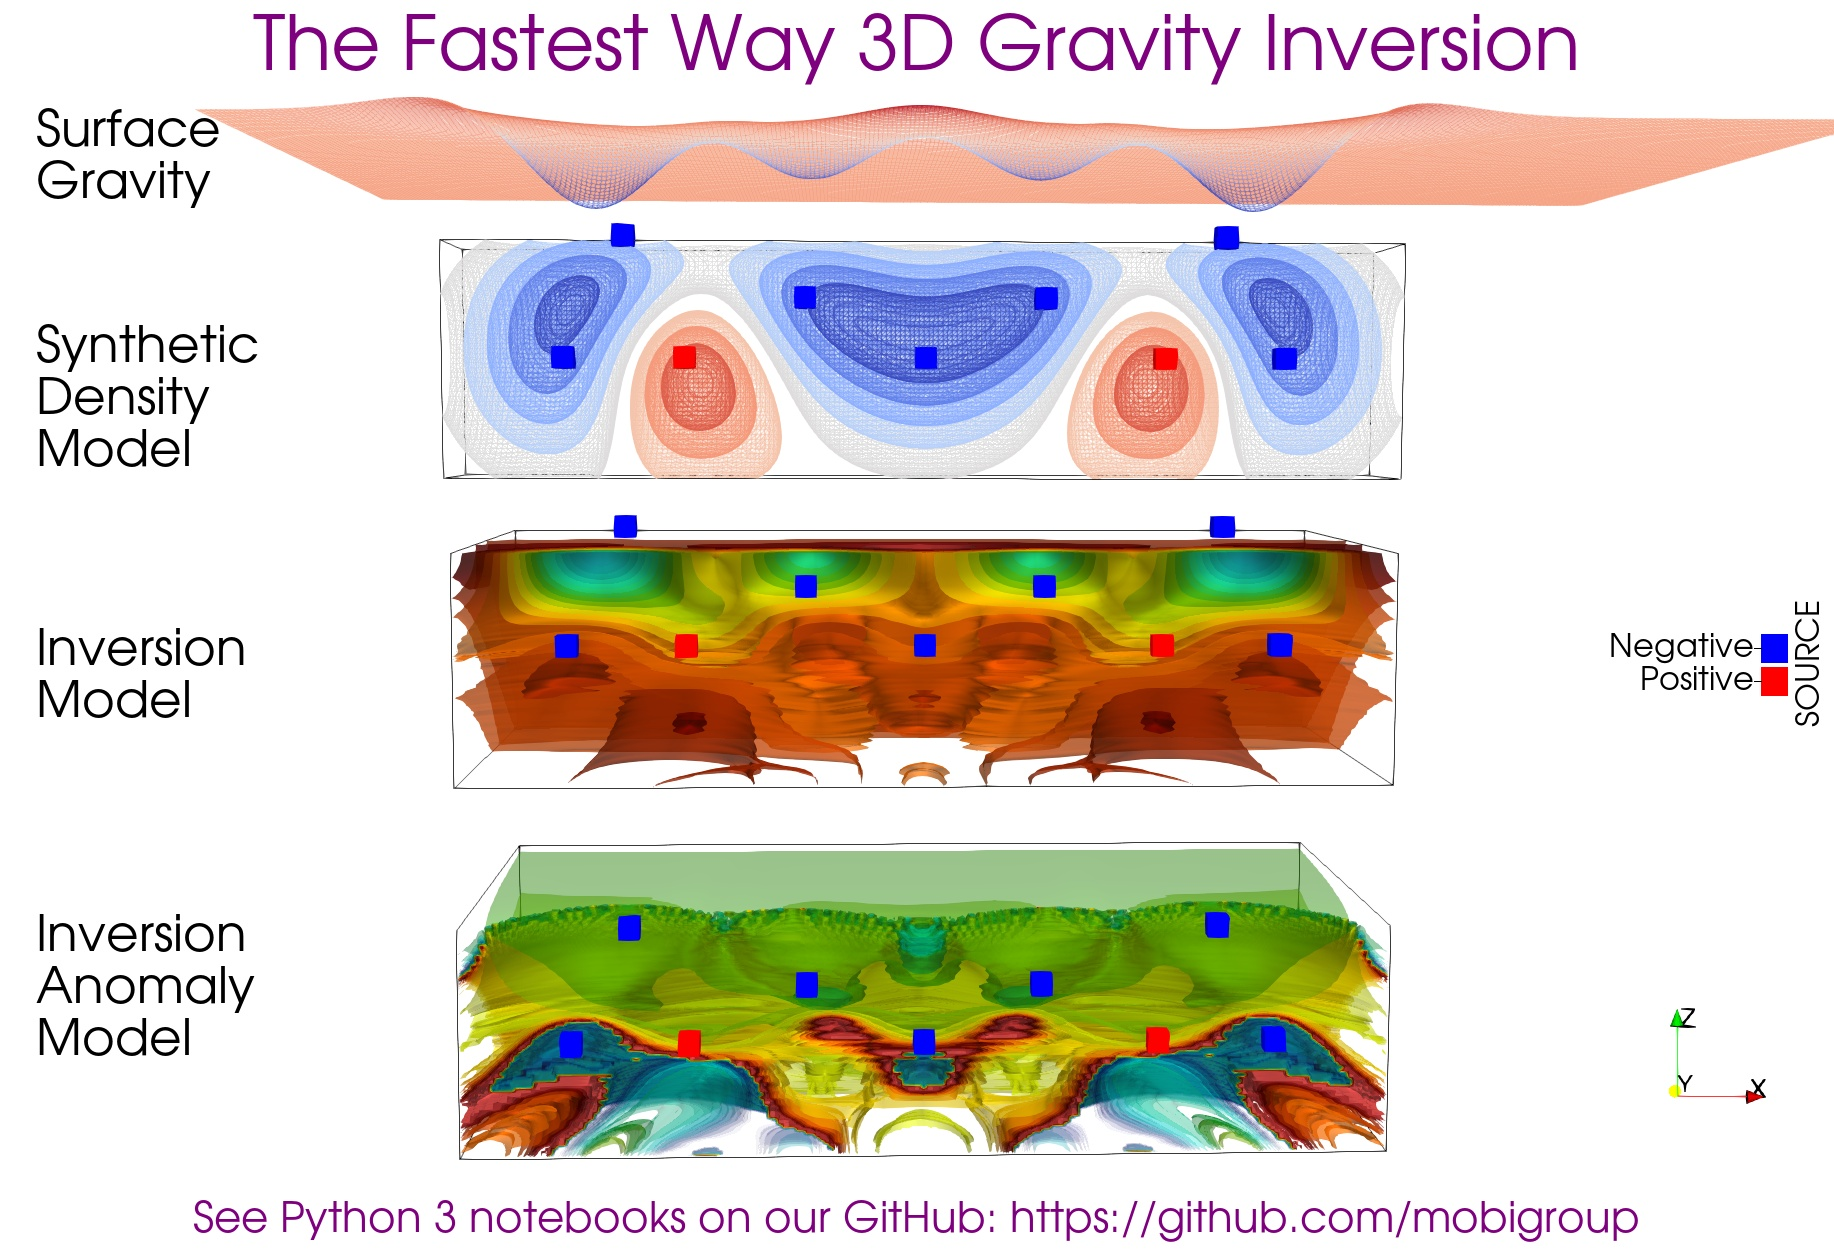

In [25]:
Image(filename='3D Synthetic Density Inversion by Circular Hough Transform [Focal Average].geomed.pvsm.jpg') 

See lots of real-world models on

**LinkedIn**: https://www.linkedin.com/in/alexey-pechnikov/

**GitHub**:   https://www.linkedin.com/in/alexey-pechnikov/

**YouTube**:  https://www.youtube.com/channel/UCSEeXKAn9f_bDiTjT6l87Lg